# Import libraries

In [7]:
import numpy as np
from matplotlib import pyplot as plt
from torch import nn, optim
from scipy.optimize import curve_fit
import sys
import os
src_path = os.path.abspath(os.path.join(os.getcwd(), '../src'))
sys.path.append(src_path)
from collision_wrapper import collOT_c as newot
from collision_wrapper import ISA_c as ISA
from utility import *
import time
import tracemalloc
from scipy.stats import linregress
from scipy.optimize import curve_fit
import psutil

# load POT
! pip3 install POT
import ot

# load pytorch
from torch import nn, optim
import torch

rng = np.random.seed(0)
size = 7;
cm = 0.393701; #inches
markers=["o", "s", "d", "<", "^"]
cls = ["blue", "red", "green", "m", "c", "brown", "gray", "salmon", "blueviolet", "lime", "chocolate"]

In [8]:
def find_optimal_map_nd(X0, Y0, numItermax=10000000):
  # X, Y with dim (Np, dim)
  n = X0.shape[0]
  a, b = np.ones((n,)) / n, np.ones((n,)) / n  # uniform distribution on samples

  # loss matrix
  M = ot.dist(X0, Y0)

  G0 = ot.emd(a, b, M, numItermax=numItermax)

  index_X = np.argmax(G0, axis=1)
  #index_Y = np.argmax(G0, axis=0)

  return X0, Y0[index_X]

def find_sinkhorn_map_nd(X0, Y0, lambd = 1e-3, numItermax=10000000):
  # X, Y with dim (Np, dim)
  n = X0.shape[0]
  a, b = np.ones((n,)) / n, np.ones((n,)) / n  # uniform distribution on samples

  # loss matrix
  M = ot.dist(X0, Y0)

  G0 = ot.sinkhorn(a, b, M, reg=lambd, numItermax=numItermax)

  index_X = np.argmax(G0, axis=1)
  #index_Y = np.argmax(G0, axis=0)

  return X0, Y0[index_X]

def fit_exp(x, y, test=None):
    log_x = np.log(x)
    log_y = np.log(y)
    if test is None:
        test = log_x
    else:
        test = np.log(test)

    slope, intercept, r_value, p_value, std_err = linregress(log_x, log_y)
    slope_str = f'{slope:.2f}'

    fitted_y = np.exp(intercept + slope * test)
    return slope, slope_str, fitted_y

def fit_xp(x, y, xp=None):
    if xp is None:
        xp = x.copy()
    log_x = np.log10(x)
    log_xp = np.log10(xp)
    log_y = np.log10(y)

    slope, intercept, r_value, p_value, std_err = linregress(log_x, log_y)
    slope_str = f'{slope:.2f}'

    fitted_y = 10**(intercept + slope * log_xp)
    return slope, slope_str, fitted_y

# Random Gaussian
Here, we generate random Gaussian distribution, as a complicated problem.

In [3]:
def sampleX_nd(Nm, Np, n):
    x = np.zeros((Nm, Np, n))
    for i in range(Nm):
        for j in range(Np):
            mu = np.random.uniform(-10,10)
            sd = 1./np.random.gamma(3., 1.)
            x[i,j, :] = np.random.normal(mu,sd,n)
    return x

In [162]:
tracemalloc.start()

dims = [5, 10, 100]
Np = 1000

errors_xy = []
mem_emd  = []
mem_sinkhorn  = []
mem_sinkhorn2  = []
mem_coll = []
mem_coll2 = []
ex_time_emd  = []
ex_time_sinkhorn  = []
ex_time_sinkhorn2  = []
ex_time_coll = []
iter_coll_xy = []
hist_coll_w = [[] for i in range(len(dims))]
err_hist_coll_w = [[] for i in range(len(dims))]
ex_time_coll2 = []
iter_coll2_xy = []
hist_coll2_w = [[] for i in range(len(dims))]
err_hist_coll2_w = [[] for i in range(len(dims))]

k=0
navg = 5
for dim in dims:
  print("dim: ", dim)
  k = k + 1

  emd_t = 0
  sinkhorn_t = 0
  sinkhorn2_t = 0
  coll_t = 0
  coll2_t = 0
  errors_xy_ = 0
  errors_yz_ = 0
  errors_xz_ = 0
  nt_xy_ = 0
  nt_yz_ = 0
  emd_avgmem = 0.0
  sinkhorn_avgmem = 0.0
  sinkhorn2_avgmem = 0.0
  coll_avgmem = 0.0
  coll2_avgmem = 0.0
  for av in range(navg):
      x00 = sampleX_nd(1, Np, dim)[0,:]
      y00 = sampleX_nd(1, Np, dim)[0,:]
    
      ## compute EMD
      tracemalloc.reset_peak()
      first_size, first_peak = tracemalloc.get_traced_memory()
      x_emd = x00.copy(); y_emd = y00.copy();
      start_time = time.time()
      x_emd, y_emd = find_optimal_map_nd(x_emd, y_emd)
      first_size, second_peak = tracemalloc.get_traced_memory()
      emd_avgmem += second_peak - first_peak
      emd_t += time.time() - start_time
      print("EMD Done")
      w_emd_xy = np.mean(np.sum((x_emd-y_emd)**2, axis=1))
      del x_emd, y_emd

      ## compute Sinkhorn
      '''
      tracemalloc.reset_peak()
      first_size, first_peak = tracemalloc.get_traced_memory()
      x_sinkhorn = x00.copy(); y_sinkhorn = y00.copy();
      start_time = time.time()
      x_sinkhorn, y_sinkhorn = find_sinkhorn_map_nd(x_sinkhorn, y_sinkhorn, lambd=10)
      first_size, second_peak = tracemalloc.get_traced_memory()
      sinkhorn_avgmem += second_peak - first_peak
      sinkhorn_t += time.time() - start_time
      print("Sinkhorn Done")
      del x_sinkhorn, y_sinkhorn
    
      ## compute Sinkhorn
      tracemalloc.reset_peak()
      first_size, first_peak = tracemalloc.get_traced_memory()
      x_sinkhorn = x00.copy(); y_sinkhorn = y00.copy();
      start_time = time.time()
      x_sinkhorn, y_sinkhorn = find_sinkhorn_map_nd(x_sinkhorn, y_sinkhorn, lambd=5)
      first_size, second_peak = tracemalloc.get_traced_memory()
      sinkhorn2_avgmem += second_peak - first_peak
      sinkhorn2_t += time.time() - start_time
      print("Sinkhorn2 Done")
      del x_sinkhorn, y_sinkhorn
      '''
      
      ## compute collision based
      tracemalloc.reset_peak()
      first_size, first_peak = tracemalloc.get_traced_memory()
      X=np.zeros((2,x00.shape[0],x00.shape[1]))
      X[0,:,:] = x00.copy()
      X[1,:,:] = y00.copy()
      start_time = time.time()
      X, dists_coll_xy, nt = newot(X, MinIter=5000, MaxIter=10000, tol = 1e-3, avg_window=20, Track=1)
      coll_t += time.time() - start_time
      first_size, second_peak = tracemalloc.get_traced_memory()
      coll_avgmem += second_peak - first_peak
      hist_coll_w[k-1].append(np.array( (dists_coll_xy)) )
      err_hist_coll_w[k-1].append( abs( np.array( (dists_coll_xy)) - w_emd_xy)/w_emd_xy )
      del X
      print("Coll Done")
    
      ## compute collision based N2
      tracemalloc.reset_peak()
      first_size, first_peak = tracemalloc.get_traced_memory()
      X=np.zeros((2,x00.shape[0],x00.shape[1]))
      X[0,:,:] = x00.copy()
      X[1,:,:] = y00.copy()
      start_time = time.time()
      X, dists_coll, nt = ISA(X, MinIter=5, MaxIter=20, tol = 1e-4, Track=1)
      coll2_t += time.time() - start_time
      first_size, second_peak = tracemalloc.get_traced_memory()
      coll2_avgmem += second_peak - first_peak
      hist_coll2_w[k-1].append(np.array( (dists_coll)) )
      err_hist_coll2_w[k-1].append( abs( np.array( (dists_coll)) - w_emd_xy)/w_emd_xy )
      del X, x00, y00
      print("ISA Done")

  mem_emd.append(emd_avgmem/navg)
  mem_coll.append(coll_avgmem/(1.*navg))
  mem_coll2.append(coll2_avgmem/(1.*navg))
  #mem_sinkhorn.append(sinkhorn_avgmem/navg)
  #mem_sinkhorn2.append(sinkhorn2_avgmem/navg)
  ex_time_emd.append(emd_t/navg)
  ex_time_coll.append(coll_t/(1.*navg))
  ex_time_coll2.append(coll2_t/(1.*navg))
  #ex_time_sinkhorn.append(sinkhorn_t/navg)
  #ex_time_sinkhorn2.append(sinkhorn2_t/navg)
  errors_xy.append( errors_xy_/navg )

dim:  5
EMD Done
Coll Done
Coll2 Done
EMD Done
Coll Done
Coll2 Done
EMD Done
Coll Done
Coll2 Done
EMD Done
Coll Done
Coll2 Done
EMD Done
Coll Done
Coll2 Done
dim:  10
EMD Done
Coll Done
Coll2 Done
EMD Done
Coll Done
Coll2 Done
EMD Done
Coll Done
Coll2 Done
EMD Done
Coll Done
Coll2 Done
EMD Done
Coll Done
Coll2 Done
dim:  100
EMD Done
Coll Done
Coll2 Done
EMD Done
Coll Done
Coll2 Done
EMD Done
Coll Done
Coll2 Done
EMD Done
Coll Done
Coll2 Done
EMD Done
Coll Done
Coll2 Done


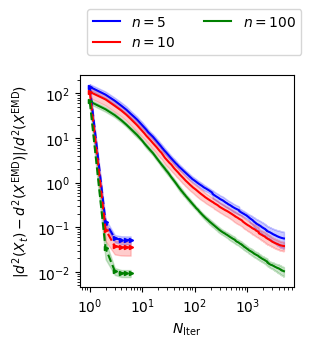

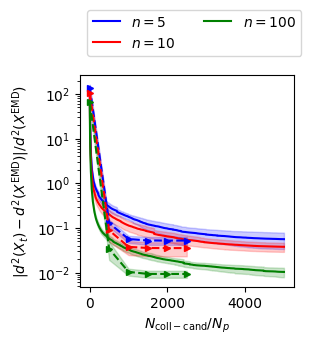

In [164]:
fig, ax = plt.subplots();
errors = []
stds = []
for k in range(0,len(dims)):
    nmin = 10000000
    for jj in range(len(err_hist_coll_w[k])):
      if len(err_hist_coll_w[k][jj]) < nmin:
        nmin = len(err_hist_coll_w[k][jj])-1
    err_hist_coll_w_k = np.zeros( (len(err_hist_coll_w[k]), nmin) )
    for jj in range(len(hist_coll_w[k])):
      for ii in range(nmin):
        err_hist_coll_w_k[jj,ii] = err_hist_coll_w[k][jj][ii]
    #nmin = 200
    xx = [i+1 for i in range(nmin)]
    mean_err = np.mean(err_hist_coll_w_k, axis=0)[:nmin]
    mean_err = mean_err #/mean_err[0]
    errors.append(mean_err[-1])
    std_err = np.var(err_hist_coll_w_k,axis=0)[:nmin]**0.5
    stds.append(std_err[-1])
    ax.plot(xx, mean_err, color=cls[k], label=r"$n="+str(dims[k])+"$", linewidth=1.5) #, markevery=30, marker="o", markersize=3)
    ax.fill_between(xx, mean_err-std_err, mean_err+std_err, color=cls[k], alpha=0.2)

    #nmin = 500
    #t = np.array([i+1 for i in range(nmin)])
    #slope, slope_str, fitted_y = fit_exp(t, mean_err[:nmin])
    #ax.plot(t, fitted_y, color=cls[k], linestyle="-.", label=r"$\propto N_\mathrm{Iter}^{"+slope_str+"}$")

#ax.set_xscale("log")
#ax.set_yscale("log")
#ax.set_ylabel(r"$| d^2(X_t) - d^2(X^\mathrm{EMD})|/ d^2(X^\mathrm{EMD})$")
#ax.set_xlabel(r"$N_\mathrm{Iter}$")
#ax.legend(loc='center left', bbox_to_anchor=(-0.1, 1.35), ncol=3)
#fig.set_size_inches(size*cm, size*cm)
#plt.savefig(str(Np)+'Np_compl_gauss_evol_rel_error_EMD_dims.pdf',format='pdf', bbox_inches="tight", dpi=300);


#fig, ax = plt.subplots();
for k in range(0,len(dims)):
    nmin = 10000000
    for jj in range(len(err_hist_coll2_w[k])):
      if len(err_hist_coll2_w[k][jj]) < nmin:
        nmin = len(err_hist_coll2_w[k][jj])-1
    err_hist_coll2_w_k = np.zeros( (len(err_hist_coll2_w[k]), nmin) )
    for jj in range(len(hist_coll2_w[k])):
      for ii in range(nmin):
        err_hist_coll2_w_k[jj,ii] = err_hist_coll2_w[k][jj][ii]
    #nmin = 200
    xx = [i+1 for i in range(nmin)]
    mean_err = np.mean(err_hist_coll2_w_k, axis=0)[:nmin]
    mean_err = mean_err #/mean_err[0]
    errors.append(mean_err[-1])
    std_err = np.var(err_hist_coll2_w_k,axis=0)[:nmin]**0.5
    stds.append(std_err[-1])
    ax.plot(xx, mean_err, color=cls[k], markevery=1, linewidth=1.5, marker=">", markersize=3, linestyle="--") #, label=r"$n="+str(dims[k])+"$")
    ax.fill_between(xx, mean_err-std_err, mean_err+std_err, color=cls[k], alpha=0.2)

    #nmin = 500
    #t = np.array([i+1 for i in range(nmin)])
    #slope, slope_str, fitted_y = fit_exp(t, mean_err[:nmin])
    #ax.plot(t, fitted_y, color=cls[k], linestyle="-.", label=r"$\propto N_\mathrm{Iter}^{"+slope_str+"}$")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylabel(r"$| d^2(X_t) - d^2(X^\mathrm{EMD})|/ d^2(X^\mathrm{EMD})$")
ax.set_xlabel(r"$N_\mathrm{Iter}$")
ax.legend(loc='center left', bbox_to_anchor=(-0.0, 1.2), ncol=2)
fig.set_size_inches(size*cm, size*cm)
#plt.savefig(str(Np)+'Np_compl_gauss_evol_rel_error_ISA_EMD_dims.pdf',format='pdf', bbox_inches="tight", dpi=300);


fig, ax = plt.subplots();
errors = []
stds = []
for k in range(0,len(dims)):
    nmin = 10000000
    for jj in range(len(err_hist_coll_w[k])):
      if len(err_hist_coll_w[k][jj]) < nmin:
        nmin = len(err_hist_coll_w[k][jj])-1
    err_hist_coll_w_k = np.zeros( (len(err_hist_coll_w[k]), nmin) )
    for jj in range(len(hist_coll_w[k])):
      for ii in range(nmin):
        err_hist_coll_w_k[jj,ii] = err_hist_coll_w[k][jj][ii]
    xx = np.array([i for i in range(nmin)])
    mean_err = np.mean(err_hist_coll_w_k, axis=0)[:nmin]
    mean_err = mean_err #/mean_err[0]
    errors.append(mean_err[-1])
    std_err = np.var(err_hist_coll_w_k,axis=0)[:nmin]**0.5 
    stds.append(std_err[-1])
    # x axis is number of collisions 2*(Np/2)*N_iter per particle Np
    xx = xx
    ax.plot(xx, mean_err, color=cls[k], label=r"$n="+str(dims[k])+"$", linewidth=1.5)#, markevery=1, marker="o", markersize=3)
    ax.fill_between(xx, mean_err-std_err, mean_err+std_err, color=cls[k], alpha=0.2)

    #nmin = 500
    #t = np.array([i+1 for i in range(nmin)])
    #slope, slope_str, fitted_y = fit_exp(t, mean_err[:nmin])
    #ax.plot(t, fitted_y, color=cls[k], linestyle="-.", label=r"$\propto N_\mathrm{Iter}^{"+slope_str+"}$")

for k in range(0,len(dims)):
    nmin = 10000000
    for jj in range(len(err_hist_coll2_w[k])):
      if len(err_hist_coll2_w[k][jj]) < nmin:
        nmin = len(err_hist_coll2_w[k][jj])-1
    err_hist_coll2_w_k = np.zeros( (len(err_hist_coll2_w[k]), nmin) )
    for jj in range(len(hist_coll2_w[k])):
      for ii in range(nmin):
        err_hist_coll2_w_k[jj,ii] = err_hist_coll2_w[k][jj][ii]
    xx = np.array([i for i in range(nmin)])
    mean_err = np.mean(err_hist_coll2_w_k, axis=0)[:nmin]
    mean_err = mean_err #/mean_err[0]
    errors.append(mean_err[-1])
    std_err = np.var(err_hist_coll2_w_k,axis=0)[:nmin]**0.5 
    stds.append(std_err[-1])
    # x axis is number of collisions 2*Np*(Np-1)/2*N_iter per particle Np
    xx = xx*(Np-1)/2
    ax.plot(xx, mean_err, color=cls[k], markevery=1, linewidth=1.5, linestyle="--", marker=">", markersize=5) #, label=r"ISA, $n="+str(dims[k])+"$")
    ax.fill_between(xx, mean_err-std_err, mean_err+std_err, color=cls[k], alpha=0.2)

    #nmin = 500
    #t = np.array([i+1 for i in range(nmin)])
    #slope, slope_str, fitted_y = fit_exp(t, mean_err[:nmin])
    #ax.plot(t, fitted_y, color=cls[k], linestyle="-.", label=r"$\propto N_\mathrm{Iter}^{"+slope_str+"}$")

#ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylabel(r"$| d^2(X_t) - d^2(X^\mathrm{EMD})|/ d^2(X^\mathrm{EMD})$")
ax.set_xlabel(r"$N_\mathrm{coll-cand}/N_p$")
#ax.legend(loc='center left', bbox_to_anchor=(-0.1, 1.35), ncol=2)
ax.legend(loc='center left', bbox_to_anchor=(-0., 1.2), ncol=2)

fig.set_size_inches(1.*size*cm, 1.*size*cm)
#plt.savefig(str(Np)+'Np_compl_gauss_tot-coll_rel_error_EMD_dims.pdf',format='pdf', bbox_inches="tight", dpi=300);


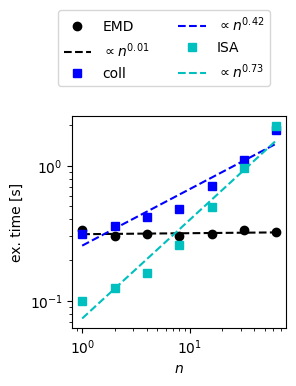

In [131]:
fig, ax = plt.subplots();

ax.plot(dims, ex_time_emd, color="black", marker="o", label="EMD", linewidth=0)
slope_emd, slope_emd_str, ex_time_emd_fit_y = fit_xp(dims, ex_time_emd)
ax.plot(dims, ex_time_emd_fit_y, label=r'$\propto n^{'+slope_emd_str+'}$', color='black', linestyle="--")

ax.plot(dims, ex_time_coll, color="blue", marker="s", label="coll", linewidth=0)
xx = np.array(dims)
slope_coll, slope_coll_str, ex_time_coll_fit_y = fit_xp(xx, ex_time_coll, xx)
ax.plot(xx, ex_time_coll_fit_y, label=r'$\propto n^{'+slope_coll_str+'}$', color='blue', linestyle="--")

ax.plot(dims, ex_time_coll2, color="c", marker="s", label="ISA", linewidth=0)
xx = np.array(dims)
slope_coll, slope_coll_str, ex_time_coll_fit_y = fit_xp(xx, ex_time_coll2, xx)
ax.plot(xx, ex_time_coll_fit_y, label=r'$\propto n^{'+slope_coll_str+'}$', color='c', linestyle="--")

#ax.plot(Nps, ex_time_sinkhorn, color="green", marker=">", label=r"sink, $\lambda=10$", linewidth=0, markersize=10)
#slope_sinkhorn, slope_sinkhorn_str, ex_time_sinkhorn_fit_y = fit_xp(Nps, ex_time_sinkhorn)
#ax.plot(Nps, ex_time_sinkhorn_fit_y, label=r'$\propto n^{'+slope_sinkhorn_str+'}$', color='green', linestyle="--")

#ax.plot(Nps, ex_time_sinkhorn2, color="red", marker="d", label=r"sink, $\lambda=5$", linewidth=0)
#slope_sinkhorn, slope_sinkhorn_str, ex_time_sinkhorn_fit_y = fit_xp(Nps, ex_time_sinkhorn2)
#ax.plot(Nps, ex_time_sinkhorn_fit_y, label=r'$\propto n^{'+slope_sinkhorn_str+'}$', color='red', linestyle="--")

plt.legend()
ax.set_xscale("log")
ax.set_yscale("log")
#ax.set_xticks([1000,10000],[r'$10^3$',r'$10^4$'])
#ax.set_xlim([400,3000])
ax.set_xlabel(r"$n$")
ax.set_ylabel(r"ex. time [s]")
ax.legend(loc='center left', bbox_to_anchor=(-0.1, 1.32),ncol=2)

fig.set_size_inches(size*cm, size*cm)
#plt.savefig(str(Np)+'Np_compl_gauss_ex_time_dim.pdf',format='pdf', bbox_inches="tight", dpi=300);

In [7]:
tracemalloc.start()

#dims = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048]
dim = 2
Nps = [1000, 2000, 4000] #, 8000, 16000]#, 16000] #, 8000] #, 16000]

errors_xy = []
mem_emd  = []
#mem_sinkhorn  = []
#mem_sinkhorn2  = []
mem_coll = []
mem_coll2 = []
ex_time_emd  = []
#ex_time_sinkhorn  = []
#ex_time_sinkhorn2  = []
ex_time_coll = []
iter_coll_xy = []
hist_coll_w = [[] for i in range(len(Nps))]
err_hist_coll_w = [[] for i in range(len(Nps))]
ex_time_coll2 = []
iter_coll2_xy = []
hist_coll2_w = [[] for i in range(len(Nps))]
err_hist_coll2_w = [[] for i in range(len(Nps))]

k=0
navg = 10
for Np in Nps:
  print("Np: ", Np, " dim: ", dim)
  k = k + 1

  emd_t = 0
  #sinkhorn_t = 0
  #sinkhorn2_t = 0
  coll_t = 0
  coll2_t = 0
  nt_xy_ = 0
  nt_yz_ = 0
  emd_avgmem = 0.0
  #sinkhorn_avgmem = 0.0
  #sinkhorn2_avgmem = 0.0
  coll_avgmem = 0.0
  coll2_avgmem = 0.0
  for av in range(navg):
      np.random.seed(navg)
      x00 = sampleX_nd(1, Np, dim)[0,:,:]
      y00 = sampleX_nd(1, Np, dim)[0,:,:]
    
      ## compute EMD
      tracemalloc.reset_peak()
      first_size, first_peak = tracemalloc.get_traced_memory()
      x_emd = x00.copy(); y_emd = y00.copy();
      start_time = time.time()
      x_emd, y_emd = find_optimal_map_nd(x_emd, y_emd)
      first_size, second_peak = tracemalloc.get_traced_memory()
      emd_avgmem += second_peak - first_peak
      emd_t += time.time() - start_time
      #print("EMD Done")
      w_emd_xy = np.mean(np.sum((x_emd-y_emd)**2, axis=1))
      #print(w_emd_xy)
      del x_emd, y_emd

      '''
      ## compute Sinkhorn
      tracemalloc.reset_peak()
      first_size, first_peak = tracemalloc.get_traced_memory()
      x_sinkhorn = x00.copy(); y_sinkhorn = y00.copy();
      start_time = time.time()
      x_sinkhorn, y_sinkhorn = find_sinkhorn_map_nd(x_sinkhorn, y_sinkhorn, lambd=20)
      first_size, second_peak = tracemalloc.get_traced_memory()
      sinkhorn_avgmem += second_peak - first_peak
      sinkhorn_t += time.time() - start_time
      print("Sinkhorn Done")
      del x_sinkhorn, y_sinkhorn
    
      ## compute Sinkhorn
      
      tracemalloc.reset_peak()
      first_size, first_peak = tracemalloc.get_traced_memory()
      x_sinkhorn = x00.copy(); y_sinkhorn = y00.copy();
      start_time = time.time()
      x_sinkhorn, y_sinkhorn = find_sinkhorn_map_nd(x_sinkhorn, y_sinkhorn, lambd=10)
      first_size, second_peak = tracemalloc.get_traced_memory()
      sinkhorn2_avgmem += second_peak - first_peak
      sinkhorn2_t += time.time() - start_time
      print("Sinkhorn2 Done")
      del x_sinkhorn, y_sinkhorn
      '''
      ## compute collision based
      tracemalloc.reset_peak()
      first_size, first_peak = tracemalloc.get_traced_memory()
      X=np.zeros((2,x00.shape[0],x00.shape[1]))
      X[0,:,:] = x00.copy()
      X[1,:,:] = y00.copy()
      start_time = time.time()
      X, dists_coll_xy, nt = newot(X, MinIter=10000, MaxIter=10000, tol = 1e-6, avg_window=50, Track=1, resh_freq=int(Np/10))
      #X, ids, dists_coll_xy, nt, Jt = find_OT_collision_nd_nmargins_new(X, Total_Cost=total_cost,  Change_Cost=change_cost, MinIter=200, MaxIter=200, tol = 1e-6, avg_window=20)
      coll_t += time.time() - start_time
      first_size, second_peak = tracemalloc.get_traced_memory()
      coll_avgmem += second_peak - first_peak
      hist_coll_w[k-1].append(np.array( (dists_coll_xy)) )
      err_hist_coll_w[k-1].append( abs( np.array( (dists_coll_xy)) - w_emd_xy)/w_emd_xy )
      #print(dists_coll_xy[-1])
      del X
      #print("Coll Done")
    
      ## compute collision based N2
      tracemalloc.reset_peak()
      first_size, first_peak = tracemalloc.get_traced_memory()
      X=np.zeros((2,x00.shape[0],x00.shape[1]))
      X[0,:,:] = x00.copy()
      X[1,:,:] = y00.copy()
      start_time = time.time()
      #X, dists_coll, nt = find_OT_N2_lp(X, MinIter=1, MaxIter=100, tol = 1e-3, p=2)
      X, dists_coll, nt = ISA(X, MinIter=5, MaxIter=5, tol = 1e-4, Track=1)
      coll2_t += time.time() - start_time
      first_size, second_peak = tracemalloc.get_traced_memory()
      coll2_avgmem += second_peak - first_peak
      hist_coll2_w[k-1].append(np.array( (dists_coll)) )
      err_hist_coll2_w[k-1].append( abs( np.array( (dists_coll)) - w_emd_xy)/w_emd_xy )
      #print(dists_coll[-1])
      del X, x00, y00
      #print("Coll2 Done with "+str(nt))

  mem_emd.append(emd_avgmem/navg)
  mem_coll.append(coll_avgmem/(1.*navg))
  mem_coll2.append(coll2_avgmem/(1.*navg))
  #mem_sinkhorn.append(sinkhorn_avgmem/navg)
  #mem_sinkhorn2.append(sinkhorn2_avgmem/navg)
  ex_time_emd.append(emd_t/navg)
  ex_time_coll.append(coll_t/(1.*navg))
  ex_time_coll2.append(coll2_t/(1.*navg))
  #ex_time_sinkhorn.append(sinkhorn_t/navg)
  #ex_time_sinkhorn2.append(sinkhorn2_t/navg)

Np:  1000  dim:  2
Np:  2000  dim:  2
Np:  4000  dim:  2


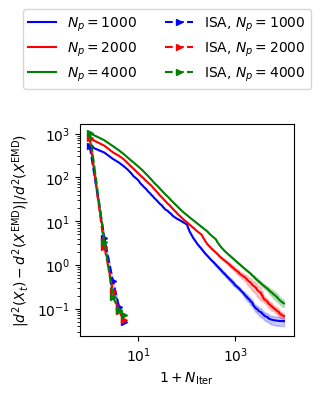

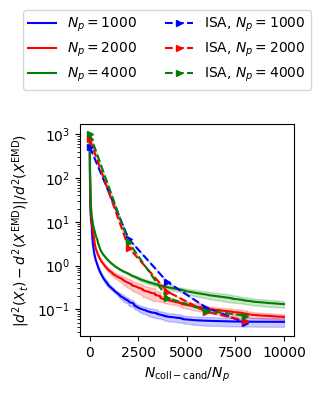

In [8]:
fig, ax = plt.subplots();
errors = []
stds = []
for k in range(0,len(Nps)):
    nmin = 10000000
    for jj in range(len(err_hist_coll_w[k])):
      if len(err_hist_coll_w[k][jj]) < nmin:
        nmin = len(err_hist_coll_w[k][jj])-1
    err_hist_coll_w_k = np.zeros( (len(err_hist_coll_w[k]), nmin) )
    for jj in range(len(hist_coll_w[k])):
      for ii in range(nmin):
        err_hist_coll_w_k[jj,ii] = err_hist_coll_w[k][jj][ii]
    xx = [i+1 for i in range(nmin)]
    mean_err = np.mean(err_hist_coll_w_k, axis=0)[:nmin]
    mean_err = mean_err #/mean_err[0]
    errors.append(mean_err[-1])
    std_err = np.var(err_hist_coll_w_k,axis=0)[:nmin]**0.5
    stds.append(std_err[-1])
    ax.plot(xx, mean_err, color=cls[k], markevery=1, label=r"$N_p="+str(Nps[k])+"$", linewidth=1.5) #, marker="o", markersize=3)
    ax.fill_between(xx, mean_err-std_err, mean_err+std_err, color=cls[k], alpha=0.2)

    #nmin = 500
    #t = np.array([i+1 for i in range(nmin)])
    #slope, slope_str, fitted_y = fit_exp(t, mean_err[:nmin])
    #ax.plot(t, fitted_y, color=cls[k], linestyle="-.", label=r"$\propto N_\mathrm{Iter}^{"+slope_str+"}$")

for k in range(0,len(Nps)):
    nmin = 10000000
    for jj in range(len(err_hist_coll2_w[k])):
      if len(err_hist_coll2_w[k][jj]) < nmin:
        nmin = len(err_hist_coll2_w[k][jj])-1
    err_hist_coll2_w_k = np.zeros( (len(err_hist_coll2_w[k]), nmin) )
    for jj in range(len(hist_coll2_w[k])):
      for ii in range(nmin):
        err_hist_coll2_w_k[jj,ii] = err_hist_coll2_w[k][jj][ii]
    xx = [i+1 for i in range(nmin)]
    mean_err = np.mean(err_hist_coll2_w_k, axis=0)[:nmin]
    mean_err = mean_err #/mean_err[0]
    errors.append(mean_err[-1])
    std_err = np.var(err_hist_coll2_w_k,axis=0)[:nmin]**0.5
    stds.append(std_err[-1])
    ax.plot(xx, mean_err, color=cls[k], markevery=1, label=r"ISA, $N_p="+str(Nps[k])+"$", linewidth=1.5, marker=">", markersize=5, linestyle="--")
    ax.fill_between(xx, mean_err-std_err, mean_err+std_err, color=cls[k], alpha=0.2)

    #nmin = 500
    #t = np.array([i+1 for i in range(nmin)])
    #slope, slope_str, fitted_y = fit_exp(t, mean_err[:nmin])
    #ax.plot(t, fitted_y, color=cls[k], linestyle="-.", label=r"$\propto N_\mathrm{Iter}^{"+slope_str+"}$")

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylabel(r"$| d^2(X_t) - d^2(X^\mathrm{EMD})|/ d^2(X^\mathrm{EMD})$")
ax.set_xlabel(r"$1+N_\mathrm{Iter}$")
#ax.legend(loc='center left', bbox_to_anchor=(-0.1, 1.35), ncol=3)
ax.legend(loc='center left', bbox_to_anchor=(-0.3, 1.35), ncol=2)

fig.set_size_inches(1.*size*cm, 1.*size*cm)
plt.savefig(str(dim)+'dim_compl_gauss_evol_rel_error_EMD_Nps.pdf',format='pdf', bbox_inches="tight", dpi=300);

fig, ax = plt.subplots();
errors = []
stds = []
for k in range(0,len(Nps)):
    nmin = 10000000
    for jj in range(len(err_hist_coll_w[k])):
      if len(err_hist_coll_w[k][jj]) < nmin:
        nmin = len(err_hist_coll_w[k][jj])-1
    err_hist_coll_w_k = np.zeros( (len(err_hist_coll_w[k]), nmin) )
    for jj in range(len(hist_coll_w[k])):
      for ii in range(nmin):
        err_hist_coll_w_k[jj,ii] = err_hist_coll_w[k][jj][ii]
    xx = np.array([i for i in range(nmin)])
    mean_err = np.mean(err_hist_coll_w_k, axis=0)[:nmin]
    mean_err = mean_err #/mean_err[0]
    errors.append(mean_err[-1])
    std_err = np.var(err_hist_coll_w_k,axis=0)[:nmin]**0.5
    stds.append(std_err[-1])
    # x axis is number of collisions 2*(Np/2)*N_iter per particle Np
    xx = xx+1
    ax.plot(xx, mean_err, color=cls[k], label=r"$N_p="+str(Nps[k])+"$", linewidth=1.5)#, markevery=1, marker="o", markersize=3)
    plt.fill_between(xx, mean_err-std_err, mean_err+std_err, color=cls[k], alpha=0.2)

    #nmin = 500
    #t = np.array([i+1 for i in range(nmin)])
    #slope, slope_str, fitted_y = fit_exp(t, mean_err[:nmin])
    #ax.plot(t, fitted_y, color=cls[k], linestyle="-.", label=r"$\propto N_\mathrm{Iter}^{"+slope_str+"}$")

for k in range(0,len(Nps)):
    nmin = 10000000
    for jj in range(len(err_hist_coll2_w[k])):
      if len(err_hist_coll2_w[k][jj]) < nmin:
        nmin = len(err_hist_coll2_w[k][jj])-1
    err_hist_coll2_w_k = np.zeros( (len(err_hist_coll2_w[k]), nmin) )
    for jj in range(len(hist_coll2_w[k])):
      for ii in range(nmin):
        err_hist_coll2_w_k[jj,ii] = err_hist_coll2_w[k][jj][ii]
    xx = np.array([i for i in range(nmin)])
    mean_err = np.mean(err_hist_coll2_w_k, axis=0)[:nmin]
    mean_err = mean_err #/mean_err[0]
    errors.append(mean_err[-1])
    std_err = np.var(err_hist_coll2_w_k,axis=0)[:nmin]**0.5
    stds.append(std_err[-1])
    # x axis is number of collisions Np*(Np-1)/2*N_iter per particle Np
    xx = xx*(Np-1)/2.+1
    ax.plot(xx, mean_err, color=cls[k], markevery=1, label=r"ISA, $N_p="+str(Nps[k])+"$", linewidth=1.5, linestyle="--", marker=">", markersize=5)
    plt.fill_between(xx, mean_err-std_err, mean_err+std_err, color=cls[k], alpha=0.2)

    #nmin = 500
    #t = np.array([i+1 for i in range(nmin)])
    #slope, slope_str, fitted_y = fit_exp(t, mean_err[:nmin])
    #ax.plot(t, fitted_y, color=cls[k], linestyle="-.", label=r"$\propto N_\mathrm{Iter}^{"+slope_str+"}$")

#ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylabel(r"$| d^2(X_t) - d^2(X^\mathrm{EMD})|/ d^2(X^\mathrm{EMD})$")
ax.set_xlabel(r"$N_\mathrm{coll-cand}/N_p$")
#ax.legend(loc='center left', bbox_to_anchor=(-0.1, 1.35), ncol=2)
ax.legend(loc='center left', bbox_to_anchor=(-0.3, 1.35), ncol=2)

fig.set_size_inches(1.*size*cm, 1.*size*cm)
#plt.savefig(str(dim)+'dim_compl_gauss_tot-coll_rel_error_EMD_Nps.pdf',format='pdf', bbox_inches="tight", dpi=300);

emd: [0.1960444927215576, 0.6302344322204589, 2.6536887884140015]


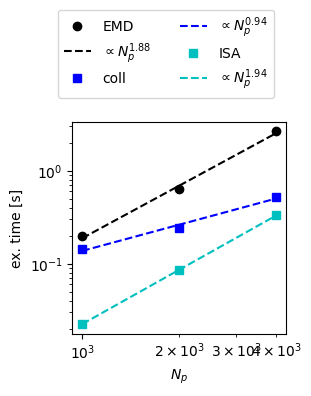

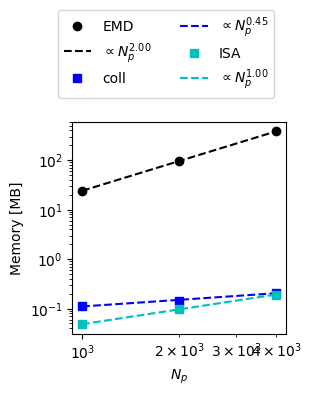

In [9]:
fig, ax = plt.subplots();

ax.plot(Nps, ex_time_emd, color="black", marker="o", label="EMD", linewidth=0)
slope_emd, slope_emd_str, ex_time_emd_fit_y = fit_xp(Nps, ex_time_emd)
ax.plot(Nps, ex_time_emd_fit_y, label=r'$\propto N_p^{'+slope_emd_str+'}$', color='black', linestyle="--")

ax.plot(Nps, ex_time_coll, color="blue", marker="s", label="coll", linewidth=0)
xx = np.array(Nps)
slope_coll, slope_coll_str, ex_time_coll_fit_y = fit_xp(xx, ex_time_coll, xx)
ax.plot(xx, ex_time_coll_fit_y, label=r'$\propto N_p^{'+slope_coll_str+'}$', color='blue', linestyle="--")

ax.plot(Nps, ex_time_coll2, color="c", marker="s", label="ISA", linewidth=0)
xx = np.array(Nps)
slope_coll, slope_coll_str, ex_time_coll_fit_y = fit_xp(xx, ex_time_coll2, xx)
ax.plot(xx, ex_time_coll_fit_y, label=r'$\propto N_p^{'+slope_coll_str+'}$', color='c', linestyle="--")

#ax.plot(Nps, ex_time_sinkhorn, color="green", marker=">", label=r"sink, $\lambda=10$", linewidth=0, markersize=10)
#slope_sinkhorn, slope_sinkhorn_str, ex_time_sinkhorn_fit_y = fit_xp(Nps, ex_time_sinkhorn)
#ax.plot(Nps, ex_time_sinkhorn_fit_y, label=r'$\propto n^{'+slope_sinkhorn_str+'}$', color='green', linestyle="--")

#ax.plot(Nps, ex_time_sinkhorn2, color="red", marker="d", label=r"sink, $\lambda=5$", linewidth=0)
#slope_sinkhorn, slope_sinkhorn_str, ex_time_sinkhorn_fit_y = fit_xp(Nps, ex_time_sinkhorn2)
#ax.plot(Nps, ex_time_sinkhorn_fit_y, label=r'$\propto n^{'+slope_sinkhorn_str+'}$', color='red', linestyle="--")

plt.legend()
ax.set_xscale("log")
ax.set_yscale("log")
#ax.set_xticks([1000,10000],[r'$10^3$',r'$10^4$'])
#ax.set_xlim([400,3000])
ax.set_xlabel(r"$N_p$")
ax.set_ylabel(r"ex. time [s]")
ax.legend(loc='center left', bbox_to_anchor=(-0.1, 1.32),ncol=2)

fig.set_size_inches(size*cm, size*cm)
#plt.savefig(str(dim)+'dim_compl_gauss_ex_time_Nps.pdf',format='pdf', bbox_inches="tight", dpi=300);

###############################################
fig, ax = plt.subplots();

ax.plot(Nps, np.array(mem_emd)/1e6, color="black", marker="o", label="EMD", linewidth=0)
slope_emd, slope_emd_str, mem_emd_fit_y = fit_xp(Nps, np.array(mem_emd)/1e6)
ax.plot(Nps, mem_emd_fit_y, label=r'$\propto N_p^{'+slope_emd_str+'}$', color='black', linestyle="--")

ax.plot(Nps, np.array(mem_coll)/1e6, color="blue", marker="s", label="coll", linewidth=0)
slope_coll, slope_coll_str, mem_coll_fit_y = fit_xp(Nps, np.array(mem_coll)/1e6)
ax.plot(Nps, mem_coll_fit_y, label=r'$\propto N_p^{'+slope_coll_str+'}$', color='blue', linestyle="--")

ax.plot(Nps, np.array(mem_coll2)/1e6, color="c", marker="s", label="ISA", linewidth=0)
slope_coll, slope_coll_str, mem_coll_fit_y = fit_xp(Nps, np.array(mem_coll2)/1e6)
ax.plot(Nps, mem_coll_fit_y, label=r'$\propto N_p^{'+slope_coll_str+'}$', color='c', linestyle="--")

#ax.plot(Nps, np.array(mem_sinkhorn)/1e6, color="green", marker=">", label=r"sink, $\lambda=10$", linewidth=0, markersize=10)
#slope_sinkhorn, slope_sinkhorn_str, mem_sinkhorn_fit_y = fit_xp(Nps, np.array(mem_sinkhorn)/1e6)
#ax.plot(Nps, mem_sinkhorn_fit_y, label=r'$\propto n^{'+slope_sinkhorn_str+'}$', color='green', linestyle="--")

#ax.plot(Nps, np.array(mem_sinkhorn2)/1e6, color="red", marker="d", label=r"sink, $\lambda=5$", linewidth=0)
#slope_sinkhorn, slope_sinkhorn_str, mem_sinkhorn_fit_y = fit_xp(Nps, np.array(mem_sinkhorn2)/1e6)
#ax.plot(Nps, mem_sinkhorn_fit_y, label=r'$\propto n^{'+slope_sinkhorn_str+'}$', color='red', linestyle="--")

plt.legend()
ax.set_xscale("log")
ax.set_yscale("log")

#ax.set_xticks([1000,10000],[r'$10^3$',r'$10^4$'])
#ax.set_xlim([400,3000])

ax.set_xlabel(r"$N_p$")
ax.set_ylabel(r"Memory [MB]")
ax.legend(loc='center left', bbox_to_anchor=(-0.1, 1.32),ncol=2)

fig.set_size_inches(size*cm, size*cm)
#plt.savefig(str(dim)+"dim_compl_gauss_mem_Nps.pdf",format='pdf', bbox_inches="tight", dpi=300);
